In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate, LSTM
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam

In [3]:
df = pd.read_csv('./dataset/sales-registry_time_series.csv',  parse_dates=[0], header=None,index_col=0, names=['date','items'])
df.head()

,items
date,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128


In [4]:
df['weekday']=[x.weekday() for x in df.index]
df['month']=[x.month for x in df.index]
df.head()

,items,weekday,month
date,,,
2017-01-02,236,0,1
2017-01-03,237,1,1
2017-01-04,290,2,1
2017-01-05,221,3,1
2017-01-07,128,5,1


In [5]:
PASOS=7
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [27]:
# load dataset
values = df['items'].values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension

scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, PASOS, 1)
reframed.reset_index(inplace=True, drop=True)

contador=0
reframed['weekday']=df['weekday']
reframed['month']=df['month']

for i in range(reframed.index[0],reframed.index[-1]):
    reframed['weekday'].loc[contador]=df['weekday'][i+8]
    reframed['month'].loc[contador]=df['month'][i+8]
    contador=contador+1
reframed.head()

C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_33560\1044631805.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  reframed['weekday'].loc[contador]=df['weekday'][i+8]
C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_33560\1044631805.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reframed['weekday'].loc[contador]=df['weekday'][i+8]
C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_33560\1044631805.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),weekday,month
0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,3.0,1.0
1,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,4.0,1.0
2,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,5.0,1.0
3,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,0.0,1.0
4,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444,1.0,1.0


In [7]:
reorder=reframed[ ['weekday','month','var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)','var1(t)'] ]
reorder.dropna(inplace=True)
reorder

C:\Users\quint.LAPTOP-LGVR2QRN\AppData\Local\Temp\ipykernel_33560\1366206473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reorder.dropna(inplace=True)


,weekday,month,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
0,3.0,1.0,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
1,4.0,1.0,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
2,5.0,1.0,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
3,0.0,1.0,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
4,1.0,1.0,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444
...,...,...,...,...,...,...,...,...,...,...
591,0.0,11.0,-0.777778,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407
592,1.0,11.0,-0.422222,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667
593,2.0,11.0,-0.425926,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074
594,3.0,11.0,-0.511111,-0.448148,-0.496296,-0.488889,-0.907407,-0.166667,-0.374074,-0.511111


In [28]:
training_data = reorder.drop('var1(t)',axis=1)#.values
target_data=reorder['var1(t)']
valid_data = training_data[595-30:595]
valid_target=target_data[595-30:595]

training_data = training_data[0:595]
target_data=target_data[0:595]
print(training_data.shape,target_data.shape,valid_data.shape,valid_target.shape)

(595, 9) (595,) (30, 9) (30,)


In [29]:
def crear_modeloEmbeddings():
    emb_dias = 2    #profundidad de embeddings
    emb_meses = 4

    in_dias = Input(shape=[1], name = 'days')
    emb_dias = Embedding(7+1, emb_dias)(in_dias)
    in_meses = Input(shape=[1], name = 'months')
    emb_meses = Embedding(12+1, emb_meses)(in_meses)

    in_cli = Input(shape=[PASOS], name = 'cli')

    fe = concatenate([(emb_dias), (emb_meses)])

    x = Flatten()(fe)
    x = Dense(PASOS,activation='tanh')(x)
    outp = Dense(1,activation='tanh')(x)
    model = Model(inputs=[in_dias,in_meses,in_cli], outputs=outp)

    model.compile(loss='mean_absolute_error', 
                  optimizer='adam',
                  metrics=['MSE'])

    model.summary()
    return model

### Let's train the neural network.

In [30]:
EPOCHS=40

model = crear_modeloEmbeddings()

continuous=training_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]
valid_continuous=valid_data[['var1(t-7)','var1(t-6)','var1(t-5)','var1(t-4)','var1(t-3)','var1(t-2)','var1(t-1)']]

history=model.fit([training_data['weekday'],training_data['month'],continuous], target_data, epochs=EPOCHS
                 ,validation_data=([valid_data['weekday'],valid_data['month'],valid_continuous],valid_target))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 days (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 months (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 1, 2)                 16        ['days[0][0]']                
                                                                                                  
 embedding_5 (Embedding)     (None, 1, 4)                 52        ['months[0][0]']              
                                                                                            

## Results

1/1 [==============================] - 0s 107ms/step
30


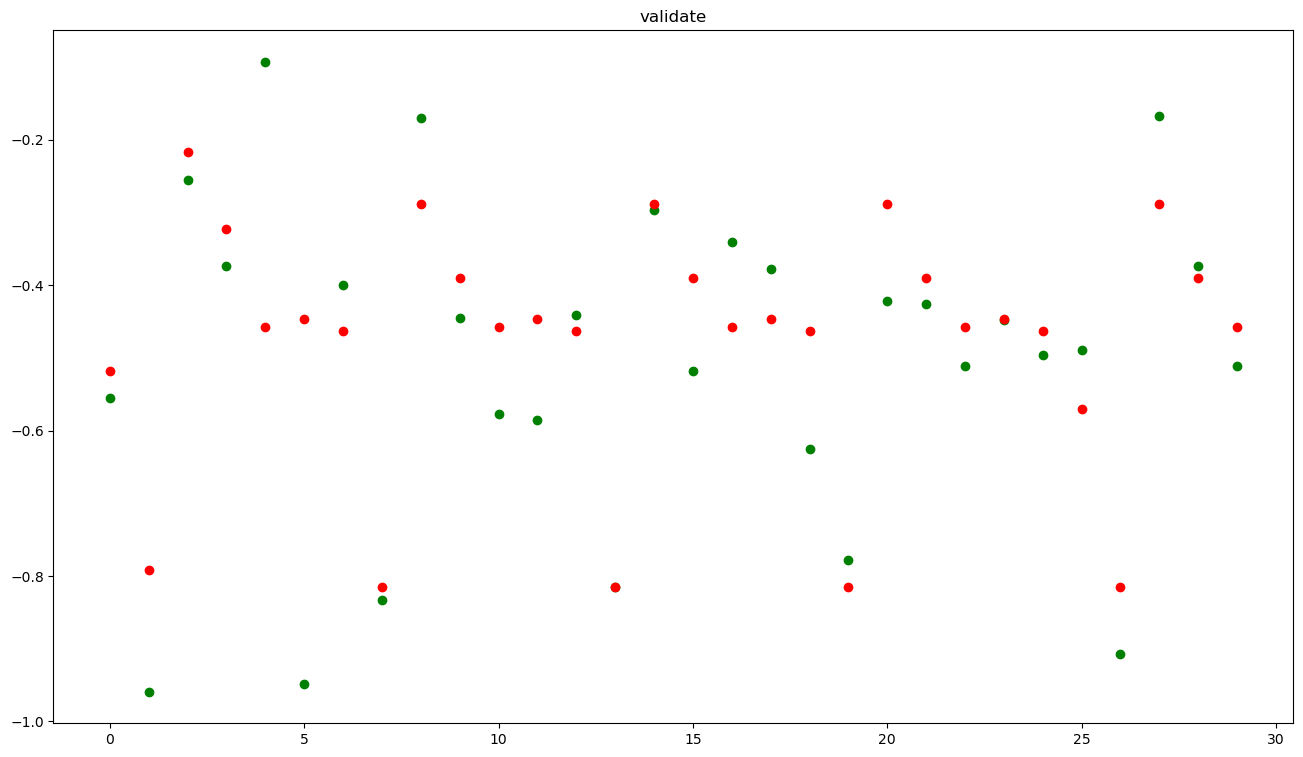

1/1 [==============================] - 0s 85ms/step


In [31]:
results=model.predict([valid_data['weekday'],valid_data['month'],valid_continuous])
print( len(results) )
plt.scatter(range(len(valid_target)),valid_target,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()
results=model.predict([[valid_data["weekday"], valid_data["month"],valid_continuous]])

#In the figure we can see the prediction of the model in red and the real data in green.

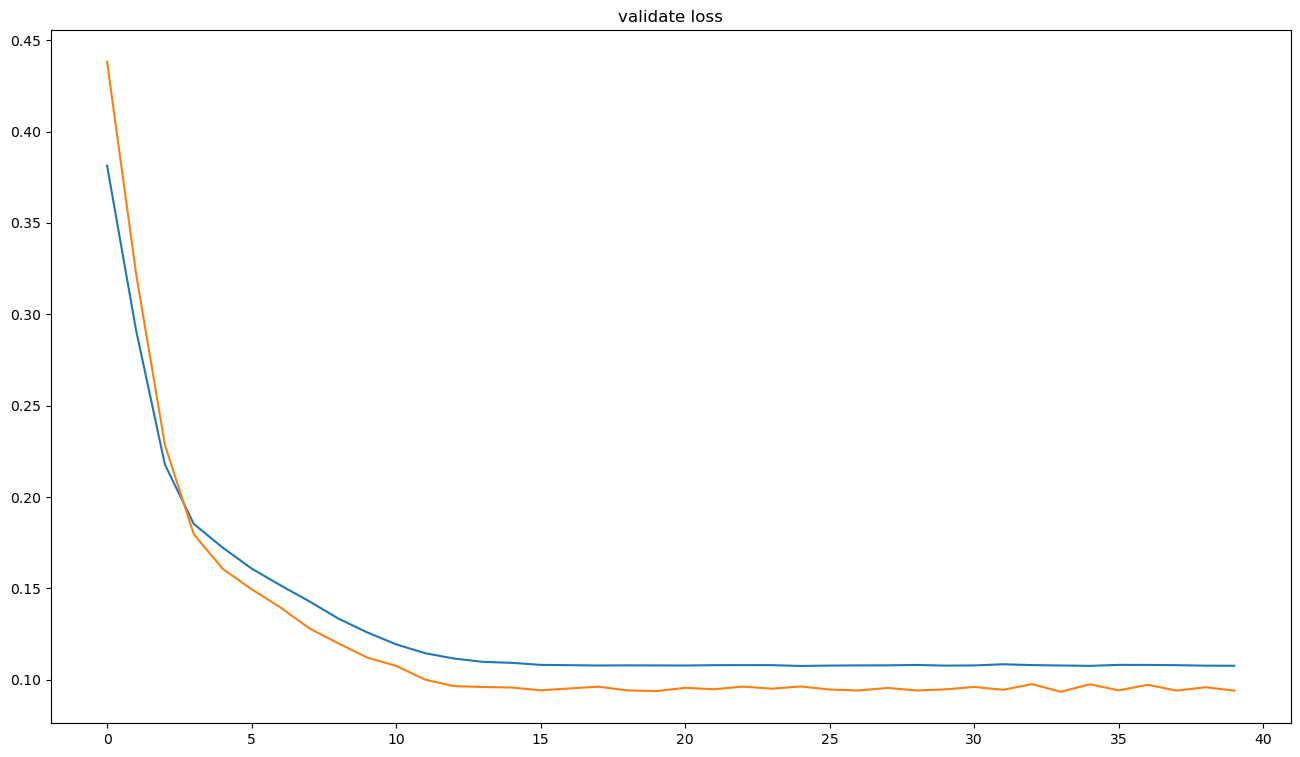

In [12]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

# "validate loss" is the loss of the validation set, and "loss" is the loss of the training set.

### From the last entries we will try to predict the future values.

In [13]:
last_days = df['2018-11-16':'2018-11-30']
last_days

,items,weekday,month
date,,,
2018-11-16,152,4,11
2018-11-17,111,5,11
2018-11-19,207,0,11
2018-11-20,206,1,11
2018-11-21,183,2,11
2018-11-22,200,3,11
2018-11-23,187,4,11
2018-11-24,189,5,11
2018-11-25,76,6,11


In [14]:
# Test subset
values = last_days.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,0.101449,-0.971014,-0.920290,-0.195652,-0.963768,-0.920290,0.500000
8,-0.971014,-0.920290,-0.195652,-0.963768,-0.920290,0.500000,-1.000000
9,-0.920290,-0.195652,-0.963768,-0.920290,0.500000,-1.000000,-0.920290
10,-0.195652,-0.963768,-0.920290,0.500000,-1.000000,-0.920290,0.492754
11,-0.963768,-0.920290,0.500000,-1.000000,-0.920290,0.492754,-0.992754
12,-0.920290,0.500000,-1.000000,-0.920290,0.492754,-0.992754,-0.920290
13,0.500000,-1.000000,-0.920290,0.492754,-0.992754,-0.920290,0.326087


In [15]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(29, 1, 7)


array([[[ 0.5       , -1.        , -0.9202899 ,  0.49275362,
         -0.9927536 , -0.9202899 ,  0.326087  ]],

       [[-1.        , -0.9202899 ,  0.49275362, -0.9927536 ,
         -0.9202899 ,  0.326087  , -0.98550725]],

       [[-0.9202899 ,  0.49275362, -0.9927536 , -0.9202899 ,
          0.326087  , -0.98550725, -0.9202899 ]],

       [[ 0.49275362, -0.9927536 , -0.9202899 ,  0.326087  ,
         -0.98550725, -0.9202899 ,  0.44927537]],

       [[-0.9927536 , -0.9202899 ,  0.326087  , -0.98550725,
         -0.9202899 ,  0.44927537, -0.9782609 ]],

       [[-0.9202899 ,  0.326087  , -0.98550725, -0.9202899 ,
          0.44927537, -0.9782609 , -0.9202899 ]],

       [[ 0.326087  , -0.98550725, -0.9202899 ,  0.44927537,
         -0.9782609 , -0.9202899 ,  0.3550725 ]],

       [[-0.98550725, -0.9202899 ,  0.44927537, -0.9782609 ,
         -0.9202899 ,  0.3550725 , -0.9710145 ]],

       [[-0.9202899 ,  0.44927537, -0.9782609 , -0.9202899 ,
          0.3550725 , -0.9710145 , -0.92028

In [16]:
def appendValue(x_test,new_value):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=new_value
    return x_test
# Function that predicts the next value based on the previous ones

In [19]:
# Predictions
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=appendValue(x_test,parcial[0])

ValueError: in user code:

    File "c:\Users\quint.LAPTOP-LGVR2QRN\.conda\envs\VSCode\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\quint.LAPTOP-LGVR2QRN\.conda\envs\VSCode\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\quint.LAPTOP-LGVR2QRN\.conda\envs\VSCode\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\quint.LAPTOP-LGVR2QRN\.conda\envs\VSCode\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\quint.LAPTOP-LGVR2QRN\.conda\envs\VSCode\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\quint.LAPTOP-LGVR2QRN\.conda\envs\VSCode\lib\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 1, 7) dtype=float32>]


In [32]:
#Undo normalization
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.5173206], dtype=float32), array([-0.79179066], dtype=float32), array([-0.21637651], dtype=float32), array([-0.32250646], dtype=float32), array([-0.4581351], dtype=float32), array([-0.44590896], dtype=float32), array([-0.46287432], dtype=float32), array([-0.8157992], dtype=float32), array([-0.28788245], dtype=float32), array([-0.38951027], dtype=float32), array([-0.4581351], dtype=float32), array([-0.44590896], dtype=float32), array([-0.46287432], dtype=float32), array([-0.8157992], dtype=float32), array([-0.28788245], dtype=float32), array([-0.38951027], dtype=float32), array([-0.4581351], dtype=float32), array([-0.44590896], dtype=float32), array([-0.46287432], dtype=float32), array([-0.8157992], dtype=float32), array([-0.28788245], dtype=float32), array([-0.38951027], dtype=float32), array([-0.4581351], dtype=float32), array([-0.44590896], dtype=float32), array([-0.46287432], dtype=float32), array([-0.5707853], dtype=float32), array([-0.8157992], dtype=float32), array([-0.

array([[181.32345342],
       [107.21652757],
       [262.57835108],
       [233.9232656 ],
       [197.30353198],
       [200.60458836],
       [196.02394123],
       [100.73422908],
       [243.27174856],
       [215.83223486],
       [197.30353198],
       [200.60458836],
       [196.02394123],
       [100.73422908],
       [243.27174856],
       [215.83223486],
       [197.30353198],
       [200.60458836],
       [196.02394123],
       [100.73422908],
       [243.27174856],
       [215.83223486],
       [197.30353198],
       [200.60458836],
       [196.02394123],
       [166.88798127],
       [100.73422908],
       [243.27174856],
       [215.83223486],
       [197.30353198]])

## Visualising the prediction results

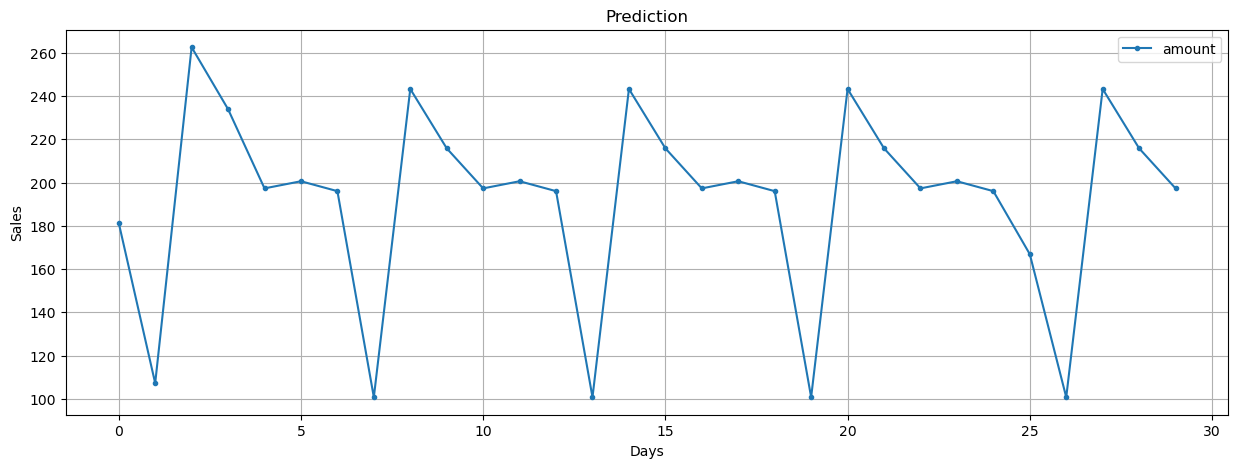

In [42]:
result_december = pd.DataFrame(inverted)

result_december.plot(style='.-', kind='line' ,figsize=(15,5),grid=True,title='Prediction')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend(['amount'], loc='upper right')
result_december.to_csv('prediction.csv')

In [34]:
result_december

,prediction
0,181.323453
1,107.216528
2,262.578351
3,233.923266
4,197.303532
5,200.604588
6,196.023941
7,100.734229
8,243.271749
9,215.832235
